In [1]:
import optax
import equinox as eqx
from jax import Array, numpy as jnp, random as jr, vmap

from matplotlib import pyplot as plt

from rssm import Model, Encoder, Decoder, rssm_loss

In [2]:
@eqx.filter_jit
def train_step(params, obs_seq, action_seq, optimizer, opt_state, key):
    def loss_fn(params):
        o_loss, kl_loss = rssm_loss(params, obs_seq, action_seq, key)
        return o_loss + kl_loss

    loss, grads = eqx.filter_value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = eqx.apply_updates(params, updates)
    return params, opt_state, loss


def make_sine_dataset(key: jr.PRNGKey, T: int, B: int) -> tuple[Array, Array]:
    t = jnp.linspace(0, 2 * jnp.pi, T)
    phases = jr.uniform(key, shape=(B,), minval=0, maxval=2 * jnp.pi)

    def per_batch(i, _):
        phase_i = phases[i]
        x = jnp.sin(t + phase_i)
        y = jnp.cos(t + phase_i)
        return x, y

    obs_list = []
    for i in range(B):
        x, y = per_batch(i, 0)
        obs_list.append(jnp.stack([x, y], axis=-1))
    obs_seq = jnp.stack(obs_list, axis=0)
    action_seq = jnp.zeros((B, T, 1))
    return obs_seq, action_seq

In [3]:
epochs = 1000
T, B = 50, 8
obs_dim, action_dim = 2, 1
obs_emb_dim, state_dim = 64, 8
rnn_hidden_dim, mlp_hidden_dim = 200, 200
key = jr.PRNGKey(0)

key, subkey = jr.split(key)
obs_seq, action_seq = make_sine_dataset(subkey, T, B)

key, subkey = jr.split(key)
rssm = Model(
    obs_emb_dim=obs_emb_dim,
    action_dim=action_dim,
    state_dim=state_dim,
    rnn_hidden_dim=rnn_hidden_dim,
    mlp_hidden_dim=mlp_hidden_dim,
    key=subkey,
)

key, subkey = jr.split(key)
encoder = Encoder(obs_dim, obs_emb_dim, mlp_hidden_dim, subkey)

key, subkey = jr.split(key)
decoder = Decoder(state_dim, rnn_hidden_dim, obs_dim, mlp_hidden_dim, subkey)

params = (rssm, encoder, decoder)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(eqx.filter(params, eqx.is_array))

for epoch in range(epochs):
    key, subkey = jr.split(key)
    params, opt_state, loss = train_step(
        params, obs_seq, action_seq, optimizer, opt_state, subkey
    )
    if epoch % 100 == 0:
        print(f"{epoch}: {loss:.5f}")

0: 1.15613
100: 0.23839
200: 0.17830
300: 0.14236
400: 0.14758
500: 0.13214
600: 0.10476
700: 0.13105
800: 0.13009
900: 0.11422


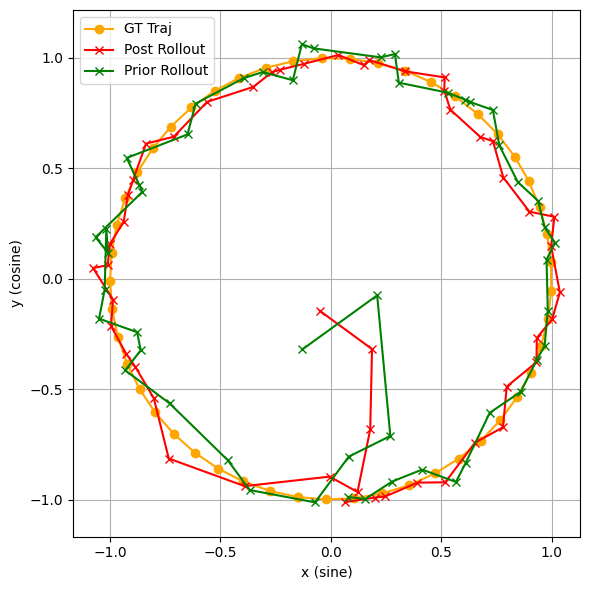

In [7]:
model, encoder, decoder = params

obs_slice = obs_seq[0]
action_slice = action_seq[0]

key, subkey = jr.split(subkey)
obs_embed_seq = vmap(encoder)(obs_slice)

init_post = model.init_post()  
post_seq, prior_seq = model.rollout(obs_embed_seq, init_post, action_slice, subkey)
pred_post_obs = vmap(decoder)(post_seq)
pred_prior_obs = vmap(decoder)(prior_seq)


plt.figure(figsize=(6, 6))
plt.plot(
    obs_slice[:, 0],
    obs_slice[:, 1],
    label="GT Traj",
    marker="o",
    color="orange",
)
plt.plot(
    pred_post_obs[:, 0],
    pred_post_obs[:, 1],
    label="Post Rollout",
    marker="x",
    color="red",
)
plt.plot(
    pred_prior_obs[:, 0],
    pred_prior_obs[:, 1],
    label="Prior Rollout",
    marker="x",
    color="green",
)
plt.legend()
plt.xlabel("x (sine)")
plt.ylabel("y (cosine)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()